# Natural Language Processing

## Part 7: TorchText + biGRU + Attention + Masking + Padded + Beam Search

Here we will be revisit biGRU and adds one improvement - beam search decoding.  Decoding based on the most probable words may not always be the best.  Allowing the network to try different possible paths may able to yield better sentences.  That is the idea of beam search decoding, i.e., parallely finding good sentences.

This is edited from https://github.com/shawnwun/NNDIAL.

In [1]:
import torch, torchdata, torchtext
from torch import nn
import torch.nn.functional as F

import random, math, time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#make our work comparable if restarted the kernel
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

cuda


In [2]:
torch.cuda.get_device_name(0)

'NVIDIA RTX A6000'

In [3]:
torch.__version__

'1.13.0+cu117'

In [4]:
torchtext.__version__

'0.14.0'

## 1. ETL: Loading the dataset

**Note**: Here I will swap to translate German to English, so we can see the quality of the generated English during inference.

In [5]:
#uncomment this if you are not using our department puffer
import os
os.environ['http_proxy']  = 'http://192.41.170.23:3128'
os.environ['https_proxy'] = 'http://192.41.170.23:3128'

from torchtext.datasets import Multi30k

SRC_LANGUAGE = 'de'
TRG_LANGUAGE = 'en'

train = Multi30k(split=('train'), language_pair=(SRC_LANGUAGE, TRG_LANGUAGE))

In [6]:
#so this is a datapipe object; very similar to pytorch dataset version 2 which is better
train

ShardingFilterIterDataPipe

## 2. EDA - simple investigation

In [7]:
#let's take a look at one example of train
sample = next(iter(train))
sample

('Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.',
 'Two young, White males are outside near many bushes.')

In [8]:
train_size = len(list(iter(train)))
train_size

29001

Since 29001 is plenty,, we gonna call `random_split` to train, val and test

In [9]:
train, val, test = train.random_split(total_length=train_size, weights = {"train": 0.7, "val": 0.2, "test": 0.1}, seed=999)

In [10]:
train_size = len(list(iter(train)))
train_size

20301

In [11]:
val_size = len(list(iter(val)))
val_size

5800

In [12]:
test_size = len(list(iter(test)))
test_size

2900

## 3. Preprocessing 

### Tokenizing

**Note**: the models must first be downloaded using the following on the command line: 
```
python3 -m spacy download en_core_web_sm
python3 -m spacy download de_core_news_sm
```

First, since we have two languages, let's create some constants to represent that.  Also, let's create two dicts: one for holding our tokenizers and one for holding all the vocabs with assigned numbers for each unique word

In [13]:
# Place-holders
token_transform = {}
vocab_transform = {}

In [14]:
from torchtext.data.utils import get_tokenizer
token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='de_core_news_sm')
token_transform[TRG_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')

In [15]:
#example of tokenization of the english part
print("Sentence: ", sample[1])
print("Tokenization: ", token_transform[SRC_LANGUAGE](sample[1]))

Sentence:  Two young, White males are outside near many bushes.
Tokenization:  ['Two', 'young', ',', 'White', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']


A function to tokenize our input.

In [16]:
# helper function to yield list of tokens
# here data can be `train` or `val` or `test`
def yield_tokens(data, language):
    language_index = {SRC_LANGUAGE: 0, TRG_LANGUAGE: 1}

    for data_sample in data:
        yield token_transform[language](data_sample[language_index[language]]) #either first or second index

Before we tokenize, let's define some special symbols so our neural network understand the embeddings of these symbols, namely the unknown, the padding, the start of sentence, and end of sentence.

In [17]:
# Define special symbols and indices
UNK_IDX, PAD_IDX, SOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<sos>', '<eos>']

### Text to integers (Numericalization)

Next we gonna create function (torchtext called vocabs) that turn these tokens into integers.  Here we use built in factory function <code>build_vocab_from_iterator</code> which accepts iterator that yield list or iterator of tokens.

In [18]:
from torchtext.vocab import build_vocab_from_iterator

for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    # Create torchtext's Vocab object 
    vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(train, ln), 
                                                    min_freq=2,   #if not, everything will be treated as UNK
                                                    specials=special_symbols,
                                                    special_first=True) #indicates whether to insert symbols at the beginning or at the end                                            
# Set UNK_IDX as the default index. This index is returned when the token is not found. 
# If not set, it throws RuntimeError when the queried token is not found in the Vocabulary. 
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    vocab_transform[ln].set_default_index(UNK_IDX)

In [19]:
#see some example
vocab_transform[TRG_LANGUAGE](['here', 'is', 'a', 'unknownword', 'a'])

[1891, 10, 4, 0, 4]

In [20]:
#we can reverse it....
mapping = vocab_transform[TRG_LANGUAGE].get_itos()

#print 1816, for example
mapping[1891]

'here'

In [21]:
#let's try unknown vocab
mapping[0]
#they will all map to <unk> which has 0 as integer

'<unk>'

In [22]:
#let's try special symbols
mapping[1], mapping[2], mapping[3]

('<pad>', '<sos>', '<eos>')

In [23]:
#check unique vocabularies
len(mapping)

5174

## 4. Preparing the dataloader

In [24]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

BATCH_SIZE = 64

# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids):
    return torch.cat((torch.tensor([SOS_IDX]), 
                      torch.tensor(token_ids), 
                      torch.tensor([EOS_IDX])))

# src and trg language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor


# function to collate data samples into batch tesors
def collate_batch(batch):
    src_batch, src_len_batch, trg_batch = [], [], []
    for src_sample, trg_sample in batch:
        processed_text = text_transform[SRC_LANGUAGE](src_sample.rstrip("\n"))
        src_batch.append(processed_text)
        trg_batch.append(text_transform[TRG_LANGUAGE](trg_sample.rstrip("\n")))
        src_len_batch.append(processed_text.size(0))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    trg_batch = pad_sequence(trg_batch, padding_value=PAD_IDX)
    return src_batch, torch.tensor(src_len_batch, dtype=torch.int64), trg_batch

Create train, val, and test dataloaders

In [25]:
batch_size = 64

train_loader = DataLoader(train, batch_size=batch_size,
                              shuffle=True, collate_fn=collate_batch)
valid_loader = DataLoader(val, batch_size=batch_size,
                              shuffle=True, collate_fn=collate_batch)
test_loader  = DataLoader(test, batch_size=batch_size,
                             shuffle=True, collate_fn=collate_batch)

Let's test the train loader.

In [26]:
for de, _, en in train_loader:
    break

In [27]:
print("English shape: ", en.shape)  # (seq len, batch_size)
print("German shape: ", de.shape)   # (seq len, batch_size)

English shape:  torch.Size([27, 64])
German shape:  torch.Size([24, 64])


## 5. Design the model

All parts are the same except the Seq2Seq part.

### Encoder

Same as part 4.

In [28]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, dropout):
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim, hid_dim, bidirectional = True)
        self.fc = nn.Linear(hid_dim * 2, hid_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_len):
        
        #src = [src len, batch size]
        #src_len = [batch size]
        
        embedded = self.dropout(self.embedding(src))
        #embedded = [src len, batch size, emb dim]
                
        #need to explicitly put lengths on cpu!
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, src_len.to('cpu'), enforce_sorted=False)
                
        packed_outputs, hidden = self.rnn(packed_embedded)        
        #packed_outputs is a packed sequence containing all hidden states
        #hidden is now from the final non-padded element in the batch
            
        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs) 
        #outputs is now a non-packed sequence, all hidden states obtained
        #  when the input is a pad token are all zeros
            
        #outputs = [src len, batch size, hid dim * num directions]
        #hidden = [n layers * num directions, batch size, hid dim]
        
        #hidden is stacked [forward_1, backward_1, forward_2, backward_2, ...]
        #outputs are always from the last layer
        
        #hidden [-2, :, : ] is the last of the forwards RNN 
        #hidden [-1, :, : ] is the last of the backwards RNN
        
        #initial decoder hidden is final hidden state of the forwards and backwards 
        #  encoder RNNs fed through a linear layer
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))
        
        #outputs = [src len, batch size, hid dim * 2]
        #hidden = [batch size, hid dim]
        
        return outputs, hidden

### Attention

No changes.

In [29]:
class Attention(nn.Module):
    def __init__(self, hid_dim):
        super().__init__()
        
        self.v = nn.Linear(hid_dim, 1, bias = False)
        self.W = nn.Linear(hid_dim,     hid_dim) #for decoder
        self.U = nn.Linear(hid_dim * 2, hid_dim) #for encoder outputs
                
    def forward(self, hidden, encoder_outputs, mask):
        
        #hidden = [batch size, hid dim]
        #encoder_outputs = [src len, batch size, hid dim * 2]
        
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        
        #repeat decoder hidden state src_len times
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        #hidden = [batch size, src len, hid dim]

        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        #encoder_outputs = [batch size, src len, hid dim * 2]
        
        energy = torch.tanh(self.W(hidden) + self.U(encoder_outputs))
        #energy = [batch size, src len, hid dim]
        
        attention = self.v(energy).squeeze(2)
        #attention = [batch size, src len]
        
        #use masked_fill_ if you want in-place
        attention = attention.masked_fill(mask, -1e10)
        
        return F.softmax(attention, dim = 1)

Let's see how the masked_fill work, just so you have faith

In [30]:
#example of masked_fill
#reall that 1 is pad_idx
x = torch.tensor([ [9, 1, 7, 2, 1, 1], [99, 1, 1, 0, 8, 9] ])

mask = (x == PAD_IDX)

x.masked_fill_(mask, -1e10)
print(x)

tensor([[           9, -10000000000,            7,            2, -10000000000,
         -10000000000],
        [          99, -10000000000, -10000000000,            0,            8,
                    9]])


### Decoder

No changes.

In [31]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, dropout, attention):
        super().__init__()

        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.gru = nn.GRU((hid_dim * 2) + emb_dim, hid_dim)
        self.fc = nn.Linear((hid_dim * 2) + hid_dim + emb_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs, mask):
             
        #input = [batch size]
        #hidden = [batch size, hid dim]
        #encoder_outputs = [src len, batch size, hid dim * 2]
        #mask = [batch size, src len]
        
        input = input.unsqueeze(0)
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        #embedded = [1, batch size, emb dim]
        
        a = self.attention(hidden, encoder_outputs, mask)
        #a = [batch size, src len]
        
        a = a.unsqueeze(1)
        #a = [batch size, 1, src len]
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        #encoder_outputs = [batch size, src len, hid dim * 2]
        
        weighted = torch.bmm(a, encoder_outputs)
        #weighted = [batch size, 1, hid dim * 2]
        
        weighted = weighted.permute(1, 0, 2)
        #weighted = [1, batch size, hid dim * 2]
        
        rnn_input = torch.cat((embedded, weighted), dim = 2)
        #rnn_input = [1, batch size, (hid dim * 2) + emb dim]
            
        output, hidden = self.gru(rnn_input, hidden.unsqueeze(0))
        #output = [seq len, batch size, dec hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        
        #seq len, n layers and n directions will always be 1 in this decoder, therefore:
        #output = [1, batch size, hid dim]
        #hidden = [1, batch size, hid dim]
        #this also means that output == hidden
        assert (output == hidden).all()
        
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        prediction = self.fc(torch.cat((output, weighted, embedded), dim = 1))
        #prediction = [batch size, output dim]
        
        return prediction, hidden.squeeze(0), a.squeeze(1)

### Putting them together (become Seq2Seq!)

Here we shall add three methods, the <code>decode</code> method which is simply a factory function that route to greedy decoding or beam search decoding.  The greedy decoding is quite straightforward.  As for the beam search, we are using `PriorityQueues` which attempts to only retrieve some top nodes with the highest probabilities.  Using PriorityQueues relieve us from implementing many boiler code for deciding which node has the highest probabilities.    **Remind that as any text generation function, the beam search function is used during inference and not during training.**

Note that beam width is a crucial factor.  In industry, 10 is often used.   Anyhow, it is important to normalize the score of node by the length (for more details, read https://arxiv.org/abs/1808.10006).   

First, we shall create a class `BeamSearchNode` to hold each of the beam node.

In [32]:
class BeamSearchNode(object):
    def __init__(self, hiddenstate, previousNode, wordId, logProb, length):
        self.h        = hiddenstate  #define the hidden state
        self.prevNode = previousNode  #where does it come from
        self.wordid   = wordId  #the numericalized integer of the word
        self.logp     = logProb  #the log probability
        self.len      = length  #the current length; first word starts at 1

    def eval(self, alpha=0.7):
        # the score will be simply the log probability penaltized by the length 
        # we add some small number to avoid division error
        # read https://arxiv.org/abs/1808.10006 to understand how alpha is selected
        return self.logp / float(self.len + 1e-6) ** (alpha)
    
    #this is the function for comparing between two beamsearchnodes, whether which one is better
    #it is called when you called "put"
    def __lt__(self, other):
        return self.len < other.len

    def __gt__(self, other):
        return self.len > other.len

In [33]:
from queue import PriorityQueue
import operator

class Seq2SeqBeam(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.device = device
        
    def create_mask(self, src):
        mask = (src != self.src_pad_idx).permute(1, 0)  #permute so it's the same shape as attention
        return mask
        
    def forward(self, src, src_len, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src len, batch size]
        #src_len = [batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is the probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.5 we use teacher forcing 50% of the time
                    
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #tensor to store attentiont outputs from decoder
        attentions = torch.zeros(trg_len, batch_size, src.shape[0]).to(self.device)
        
        #encoder_outputs is all hidden states of the input sequence, back and forwards
        #hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outputs, hidden = self.encoder(src, src_len)
                
        #first input to the decoder is the <sos> tokens
        input_ = trg[0,:]
        
        mask = self.create_mask(src)
        #mask = [batch size, src len]
                
        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden state, all encoder hidden states 
            #  and mask
            #receive output tensor (predictions) and new hidden state
            output, hidden, attention = self.decoder(input_, hidden, encoder_outputs, mask)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #place attentions in a tensor holding attention for each token
            attentions[t] = attention
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input_ = trg[t] if teacher_force else top1
            
        return outputs, attentions
    
    
    #use during inference
    #encapsulates beam_decode or greedy_decode
    def decode(self, src, src_len, trg, method='beam-search'):
        
        #src = [src len, batch size]
        #trg = [trg len, batch size]
        #src len = [batch size]

        encoder_outputs, hidden = self.encoder(src, src_len) 
        #encoder_outputs = [src len, batch size, hid dim * 2]  (*2 because of bidirectional)(every hidden states)
        #hidden = [batch size, hid dim]  #final hidden state
       
        hidden = hidden.unsqueeze(0)
        #hidden = [1, batch size, hid dim]
        
        if method == 'beam-search':
            return self.beam_decode(src, trg, hidden, encoder_outputs)
        else:
            return self.greedy_decode(trg, hidden, encoder_outputs)

    def greedy_decode(self, trg, decoder_hidden, encoder_outputs):
        pass

    def beam_decode(self, src_tensor, target_tensor, decoder_hiddens, encoder_outputs=None):
        #src_tensor      = [src len, batch size]
        #target_tensor   = [trg len, batch size]
        #decoder_hiddens = [1, batch size, hid dim]
        #encoder_outputs = [src len, batch size, hid dim * 2]
        
        target_tensor = target_tensor.permute(1, 0)
        #target_tensor = [batch size, trg len]
        
        #how many parallel searches
        beam_width = 3
        
        #how many sentence do you want to generate
        topk = 1  
        
        #final generated sentence
        decoded_batch = []
                
        #Another difference is that beam_search_decoding has 
        #to be done sentence by sentence, thus the batch size is indexed and reduced to only 1.  
        #To keep the dimension same, we unsqueeze 1 dimension for the batch size.
        for idx in range(target_tensor.size(0)):  # batch_size
            
            #decoder_hiddens = [1, batch size, dec hid dim]
            decoder_hidden = decoder_hiddens[:, idx, :]
            #decoder_hidden = [1, dec hid dim]
            
            #encoder_outputs = [src len, batch size, enc hid dim * 2]
            encoder_output = encoder_outputs[:, idx, :].unsqueeze(1)
            #encoder_output = [src len, 1, enc hid dim * 2]
            
            mask = self.create_mask(src_tensor[:, idx].unsqueeze(1))
            # print("mask shape: ", mask.shape)
            
            #mask = [1, src len]

            # Start with the start of the sentence token
            decoder_input = torch.LongTensor([SOS_IDX]).to(device)

            # Number of sentence to generate
            endnodes = []  #hold the nodes of EOS, so we can backtrack
            number_required = min((topk + 1), topk - len(endnodes))

            # starting node -  hidden vector, previous node, word id, logp, length
            node = BeamSearchNode(decoder_hidden, None, decoder_input, 0, 1)
            nodes = PriorityQueue()  #this is a min-heap

            # start the queue
            nodes.put((-node.eval(), node))  #we need to put - because PriorityQueue is a min-heap
            qsize = 1

            # start beam search
            while True:
                # give up when decoding takes too long
                if qsize > 2000: break

                # fetch the best node
                # score is log p divides by the length scaled by some constants
                score, n = nodes.get()
                            
                # wordid is simply the numercalized integer of the word
                decoder_input  = n.wordid
                decoder_hidden = n.h

                if n.wordid.item() == EOS_IDX and n.prevNode != None:
                    endnodes.append((score, n))
                    # if we reached maximum # of sentences required
                    if len(endnodes) >= number_required:
                        break
                    else:
                        continue

                # decode for one step using decoder
                # decoder_input = SOS_IDX
                # decoder_hidden = [1, hid dim]
                # encoder_output = [src len, 1, hid dim * 2]
                # mask = [1, src len]
                
                prediction, decoder_hidden, _ = self.decoder(decoder_input, decoder_hidden, encoder_output, mask)
                #prediction     = [1, output dim]  #1 because the batch size is 1
                #decoder hidden = [1, hid dim]

                #so basically prediction is probabilities across all possible vocab
                #we gonna retrieve k top probabilities (which is defined by beam_width) and their indexes
                #recall that beam_width defines how many parallel searches we want
                log_prob, indexes = torch.topk(prediction, beam_width)
                # log_prob      = (1, beam width)
                # indexes       = (1, beam width)
                
                nextnodes = []  #the next possible node you can move to

                # we only select beam_width amount of nextnodes
                for top in range(beam_width):
                    pred_t = indexes[0, top].reshape(-1)  #reshape because wordid is assume to be []; see when we define SOS
                    log_p  = log_prob[0, top].item()
                                    
                    #decoder hidden, previous node, current node, prob, length
                    node = BeamSearchNode(decoder_hidden, n, pred_t, n.logp + log_p, n.len + 1)
                    score = -node.eval()
                    nextnodes.append((score, node))

                # put them into queue
                for i in range(len(nextnodes)):
                    score, nn = nextnodes[i]
                    nodes.put((score, nn))
                    # increase qsize
                qsize += len(nextnodes) - 1

            # Once everything is finished, choose nbest paths, back trace them
            
            ## in case it does not finish, we simply get couple of nodes with highest probability
            if len(endnodes) == 0:
                endnodes = [nodes.get() for _ in range(topk)]

            #look from the end and go back....
            utterances = []
            for score, n in sorted(endnodes, key=operator.itemgetter(0)):
                utterance = []
                utterance.append(n.wordid)
                # back trace by looking at the previous nodes.....
                while n.prevNode != None:
                    n = n.prevNode
                    utterance.append(n.wordid)

                utterance = utterance[::-1]  #reverse it....
                utterances.append(utterance) #append to the list of sentences....

            decoded_batch.append(utterances)

        return decoded_batch  #(batch size, length)

#### In case you don't understand the `topk` part; here is step by step

In [34]:
import torch

In [35]:
#imagine these are probabilities across all vocabs
prediction = torch.FloatTensor([[1, 2, 3, 4, 5, 6, 7]])  

In [36]:
prediction.shape

torch.Size([1, 7])

In [37]:
log_prob, indexes = torch.topk(prediction, 3)

In [38]:
print(indexes.shape) #(batch size, beam width)
indexes

torch.Size([1, 3])


tensor([[6, 5, 4]])

In [39]:
print(log_prob.shape) #(batch size, beam width)
log_prob

torch.Size([1, 3])


tensor([[7., 6., 5.]])

In [40]:
beam_width = 3 #e.g.,
for top in range(beam_width):
    pred_t = indexes[:, top]
    print("pred_t: ", pred_t)
    log_p = log_prob[:, top].item()
    print("log_p: ", log_p) 

pred_t:  tensor([6])
log_p:  7.0
pred_t:  tensor([5])
log_p:  6.0
pred_t:  tensor([4])
log_p:  5.0


#### In case you don't understand how `PriorityQueue` works

In [41]:
from queue import PriorityQueue

In [42]:
nodes = PriorityQueue()

In [43]:
nodes

In [44]:
nodes.put((-0.8, "some node"))

In [45]:
nodes

In [46]:
nodes.put((-0.5, "some node"))

In [47]:
nodes.put((-0.9, "some node"))

In [48]:
score, n = nodes.get()

In [49]:
score, n  #so it retrieve the lowest number, that is why we need to put negative sign when we put inside

(-0.9, 'some node')

## 6. Training

In [50]:
def initialize_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)

In [51]:
input_dim   = len(vocab_transform[SRC_LANGUAGE])
output_dim  = len(vocab_transform[TRG_LANGUAGE])
emb_dim     = 256  
hid_dim     = 512  
dropout     = 0.5
SRC_PAD_IDX = PAD_IDX

attn = Attention(hid_dim)
enc  = Encoder(input_dim,  emb_dim,  hid_dim, dropout)
dec  = Decoder(output_dim, emb_dim,  hid_dim, dropout, attn)

model = Seq2SeqBeam(enc, dec, SRC_PAD_IDX, device).to(device)
model.apply(initialize_weights)

Seq2SeqBeam(
  (encoder): Encoder(
    (embedding): Embedding(6433, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (v): Linear(in_features=512, out_features=1, bias=False)
      (W): Linear(in_features=512, out_features=512, bias=True)
      (U): Linear(in_features=1024, out_features=512, bias=True)
    )
    (embedding): Embedding(5174, 256)
    (gru): GRU(1280, 512)
    (fc): Linear(in_features=1792, out_features=5174, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [52]:
#we can print the complexity by the number of parameters
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model)

1646848
393216
786432
  1536
  1536
393216
786432
  1536
  1536
524288
   512
   512
262144
   512
524288
   512
1324544
1966080
786432
  1536
  1536
9271808
  5174
______
18682166


In [53]:
import torch.optim as optim

lr = 0.001

#training hyperparameters
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX) #combine softmax with cross entropy

No changes to the training.

In [54]:
def train(model, loader, optimizer, criterion, clip, loader_length):
    
    model.train()
    epoch_loss = 0
    
    for src, src_length, trg in loader:
        
        src = src.to(device)
        trg = trg.to(device)
        
        optimizer.zero_grad()
        
        output, attentions = model(src, src_length, trg)
        
        #trg    = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        output_dim = output.shape[-1]
        
        #the loss function only works on 2d inputs with 1d targets thus we need to flatten each of them
        output = output[1:].view(-1, output_dim)
        trg    = trg[1:].view(-1)
        #trg    = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        #clip the gradients to prevent them from exploding (a common issue in RNNs)
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / loader_length

Here, we are calling our implemented beam-search function <code>decode</code>.  To show it, we print some sample so we can take a look.

In [55]:
def evaluate(model, loader, criterion, loader_length):
    
    model.eval()
    epoch_loss = 0
    decoded_batch_list = []

    with torch.no_grad():
    
        for src, src_len, trg in loader:
        
            #put them to GPU
            src = src.to(device)
            trg = trg.to(device)
            #src = [src len, batch size]
            #trg = [src len, batch size]
            #src_len = [batch size]

            #turn off teacher forcing
            #make prediction
            output, attentions = model(src, src_len, trg, 0) 
            #output = [trg len, batch size, output dim]

            #decoding using beam_search as example (you don't need to put here, because beam_search is for intference)
            decoded_batch = model.decode(src, src_len, trg, method='beam-search')
            #len(decoded_batch) = 64
            #len(decoded_batch[0]) = 1 = number of sentence generated, i.e., topk            
            decoded_batch_list.append(decoded_batch)
            
            #remove the first output (SOS) and then reshape both output and trg so we can calculate loss
            output_dim = output.shape[-1]
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)
            #trg    = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            epoch_loss += loss.item()
        
        #this is optional; you don't have to; printing first three samples of the first batch
        print("print samples from first decode batch")
        for sentence_index in decoded_batch_list[0][:3]:
            decode_text_arr = [vocab_transform[TRG_LANGUAGE].lookup_token(i) for i in sentence_index[0]]
            decode_sentence = " ".join(decode_text_arr[1:-1])  #no need sos and eos
            print("pred target : {}".format(decode_sentence))
        
    return epoch_loss / loader_length

### Putting everything together

In [56]:
train_loader_length = len(list(iter(train_loader)))
val_loader_length   = len(list(iter(valid_loader)))
test_loader_length  = len(list(iter(test_loader)))

In [57]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [58]:
best_valid_loss = float('inf')
num_epochs = 5  #<----for the sake of brevity
clip       = 1

save_path = f'models/{model.__class__.__name__}.pt'

train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    
    start_time = time.time()

    train_loss = train(model, train_loader, optimizer, criterion, clip, train_loader_length)
    valid_loss = evaluate(model, valid_loader, criterion, val_loader_length)
    
    #for plotting
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), save_path)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
    
    #lower perplexity is better

print samples from first decode batch
pred target : Two men are in a a . .
pred target : A man in a blue shirt is a a a .
pred target : A man in a a a a a a .
Epoch: 01 | Time: 1m 16s
	Train Loss: 4.884 | Train PPL: 132.189
	 Val. Loss: 4.728 |  Val. PPL: 113.082
print samples from first decode batch
pred target : Two men are in a a a .
pred target : A woman is a a a a a a a . .
pred target : A group of people are standing in a a of a <unk> .
Epoch: 02 | Time: 1m 23s
	Train Loss: 4.105 | Train PPL:  60.662
	 Val. Loss: 4.469 |  Val. PPL:  87.265
print samples from first decode batch
pred target : A woman in a a is standing in front of a table .
pred target : A man in a white shirt .
pred target : People are walking down a street .
Epoch: 03 | Time: 1m 23s
	Train Loss: 3.758 | Train PPL:  42.852
	 Val. Loss: 4.176 |  Val. PPL:  65.116
print samples from first decode batch
pred target : The race race race through the race .
pred target : A girl in a red shirt is a a a in a white dog .
pr

Text(0, 0.5, 'loss')

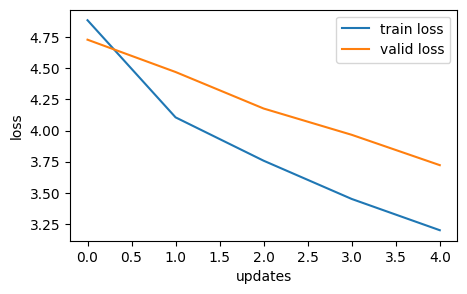

In [59]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

In [60]:
model.load_state_dict(torch.load(save_path))
test_loss = evaluate(model, test_loader, criterion, test_loader_length)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

print samples from first decode batch
pred target : Two black dogs run through the snow with a .
pred target : A couple of a <unk> , a a a a a a a on a sunny day .
pred target : Two men are sitting in a room with two men .
| Test Loss: 3.693 | Test PPL:  40.175 |


## Conclusion

Nice!  You now learned beam-search decoding.  Not so difficult, right?